# imports

In [17]:
import warnings
warnings.simplefilter('ignore')

In [18]:
import torch
torch.cuda.empty_cache()

In [19]:
import pandas as pd
import numpy as np
import math
from torch import nn

# import torch
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision
import matplotlib.pyplot as plt
import seaborn as sns
# from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report, ConfusionMatrixDisplay

In [20]:
df = pd.read_csv('fer2013.csv')
print(df.shape)
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [21]:
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1], dtype=int64)

In [22]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

In [23]:
df.emotion.value_counts()

emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: count, dtype: int64

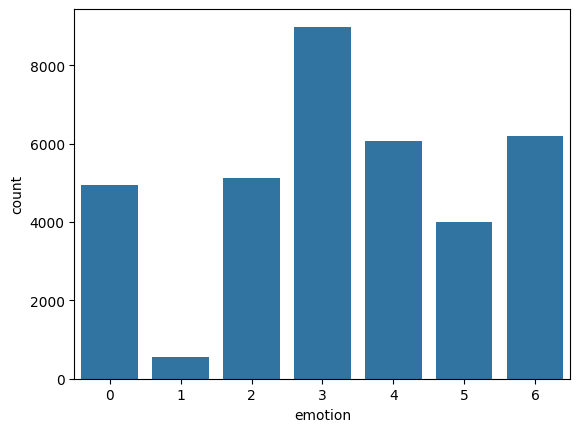

In [24]:
sns.countplot(x=df['emotion'])
plt.show()

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


since we have less amount of disgust (1) data we will drop the 1 part

In [26]:
df = df.drop(df[(df['emotion'] == 1) | (df['emotion'] == 2)| (df['emotion'] == 4)].index, axis=0)

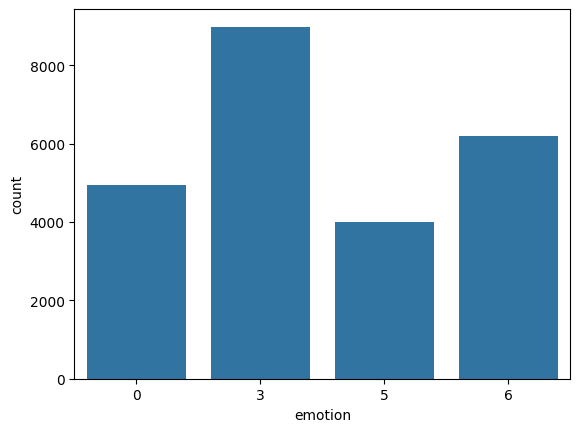

In [27]:
sns.countplot(x=df['emotion'])
plt.show()

In [28]:
math.sqrt(len(df.pixels[0].split(' ')))

48.0

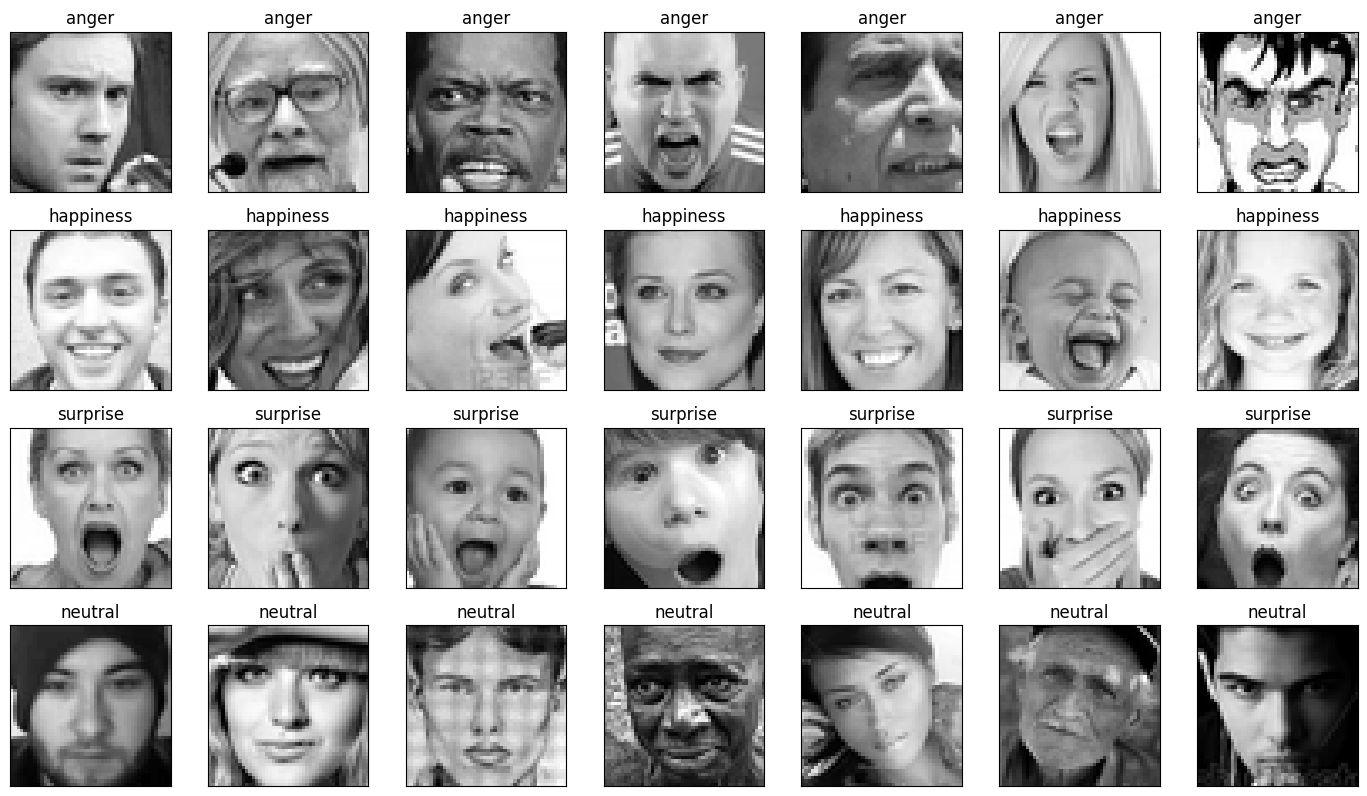

In [29]:
fig = plt.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = plt.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        plt.tight_layout()

`Now I will make the data compatible for neural networks.`

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24142 entries, 0 to 35885
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  24142 non-null  int64 
 1   pixels   24142 non-null  object
 2   Usage    24142 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


In [33]:
df.emotion.nunique()

4

In [34]:
df = df.reset_index(drop=True)

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24142 entries, 0 to 24141
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  24142 non-null  int64 
 1   pixels   24142 non-null  object
 2   Usage    24142 non-null  object
dtypes: int64(1), object(2)
memory usage: 566.0+ KB


In [36]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

In [37]:
def chang(emotion):
    if emotion==3:
        emotion-=2
    if emotion==5:
        emotion-=3
    if emotion==6:
        emotion-=3
    return emotion

In [38]:
df['emotion'] = df.emotion.apply(chang)

In [39]:
df.emotion.value_counts()

emotion
1    8989
3    6198
0    4953
2    4002
Name: count, dtype: int64

In [40]:
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,3,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
3,1,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
4,1,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training


In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device('cpu')
print(f'device name {device}')

device name cuda


In [42]:
from torchvision.io import read_image
from torch.utils.data import Dataset
from PIL import Image
class custom_dataset(Dataset):
    def __init__(self,data,transform=None,target_transform=None):
        self.data = data
        self.transform = transform
        self.target_transform = target_transform
    def __len__(self):
        return (len(self.data))
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Get pixel values and label from DataFrame
        pixel= df.iloc[idx, 1].split(' ')
        pixels = np.array(pixel).astype(np.uint8)
        label = self.data.iloc[idx, 0]
        
        # Reshape pixel values to image dimensions (assuming square images)
        image = pixels.reshape(48, 48) # Adjust dimensions as needed
        image = Image.fromarray(image)
        image = image.convert('RGB')
        # Convert to PIL image
#         image = Image.fromarray(image)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label
    

In [43]:
import torchvision.transforms as transforms

In [44]:
transform = transforms.Compose([
    transforms.RandomRotation(degrees=15),           # Randomly rotate by ±15 degrees
    transforms.RandomHorizontalFlip(p=0.5),          # Randomly flip horizontally with a probability of 0.5
    transforms.RandomResizedCrop(size=(48, 48), scale=(0.8, 1.0)),  # Randomly crop and resize
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust brightness, contrast, saturation, and hue
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Randomly translate horizontally and vertically
    transforms.RandomApply([transforms.Grayscale(num_output_channels=3)], p=0.1),  # Randomly convert to grayscale
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.1),        # Randomly apply Gaussian blur
    transforms.ToTensor(),                          # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])     # Normalize
])

In [45]:
dataset = custom_dataset(data=df, transform=transform,target_transform=None)

# dataset2 = custom_dataset(data=df, transform=transform2,target_transform=None)

# dataset = torch.utils.data.ConcatDataset([dataset1, dataset2])
# Example accessing data
image, label = dataset[2]
print("Label:", label)
print("Image shape:", image.shape)

Label: 3
Image shape: torch.Size([3, 48, 48])


In [47]:
from torch.utils.data import random_split

In [48]:
# Split dataset into training and validation sets
train_size = int(0.8 * len(dataset))
print(train_size)
val_size = len(dataset) - train_size
print(val_size)
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Define data loaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

19313
4829


In [49]:
import torch.nn as nn
import torchvision.models as models

class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.base_model = models.vgg19(pretrained=True)
        # Change the last fully connected layer to output num_classes
        self.fc = nn.Linear(1000, num_classes)

    def forward(self, x):
        x = self.base_model(x)
        x = self.fc(x)
        return x

# Initialize model, loss function, and optimizer
model = CNNModel(num_classes=4) 
model=model.to(device)

In [50]:
model.eval()

CNNModel(
  (base_model): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      

In [51]:
def train_loop(dataloader,model,loss_fn,optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch,(X,y) in enumerate(dataloader):
        # Compute prediction and loss
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred,y)
        #backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if batch%100 == 0:
            loss,current=loss.item(),batch*batch_size+len(X)
            print(f'loss:{loss:7f}  [{current:>5d}/{size:>5d}]')

In [52]:
def test_loop(dataloader,model,loss_fun):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss,correct=0,0
    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X,y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss+=loss_fun(pred,y).item()
            correct+= (pred.argmax(1)==y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct/= size
    print(f'Test Error:\n Accuracy:{100*correct:0.1f}%, Avg loss: {test_loss:>8f}\n')
    return test_loss

In [ ]:
loss_fun = nn.CrossEntropyLoss()
import torch.optim as optim

learning_rate = 0.0001
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8

optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(beta1, beta2), eps=epsilon)

epochs = 100
# prev_avg_loss = float('inf')
epochs_since_last_improvement = 0
best_val_loss = float('inf')
patience = 5  # Stop training if loss doesn't decrease for 5 consecutive epochs

for t in range(epochs):
    print(f'Epoch {t+1}\n--------------')
    train_loop(train_loader, model, loss_fun, optimizer)
    avg_loss = test_loop(val_loader, model, loss_fun)
    print('Test Error:')
    print(f' Avg loss: {avg_loss}')
    
    if avg_loss < best_val_loss:
        # Update best validation loss
        best_val_loss = avg_loss
        epochs_without_improvement = 0
        # Save the model checkpoint
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        # Increment epochs without improvement
        epochs_without_improvement += 1
        
        # Check if early stopping criteria met
        if epochs_without_improvement >= patience:
            print(f'Validation loss did not improve for {patience} epochs. Early stopping...')
            break
print('Done')

Epoch 1
--------------
loss:0.695090  [  128/19313]
loss:0.611658  [12928/19313]


In [ ]:
# Load the saved model state dictionary on the appropriate device
model.load_state_dict(torch.load('best_model.pth', map_location=device))
model.to(device)

In [54]:
from PIL import Image
import os
import torch.nn.functional as F
# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.transform = transform
        self.image_paths = os.listdir(image_folder)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        
        image_name = self.image_paths[idx]
        image_path = os.path.join(self.image_folder, image_name)
        image = Image.open(image_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        return image


In [55]:
# Path to your test set images
val_image_folder = "image_path"

# Create dataset instance
val_dataset = CustomDataset(val_image_folder,transform=transform)

# Create data loader
batch_size = 64  # Adjust according to your memory constraints
val_loader = DataLoader(val_dataset, shuffle=False)
Code=[]
# Iterate over batches and perform prediction
for batch_idx, images in enumerate(val_loader):
    images = images.to(device)
    # Perform prediction using your model
    # Replace this with your prediction code
    with torch.no_grad():
        predictions = model(images)
    probabilities = F.softmax(predictions, dim=1)
    # Process predictions as needed
    # Replace this with your post-processing code
    _, predicted_classes = torch.max(probabilities, 1)
    Code.append(predicted_classes.item())
#     print("Predicted classes:", predicted_classes)
print(Code)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'image_path'

In [ ]:
fig = plt.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = plt.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        plt.tight_layout()